# Using the BayesFactor package

We'll now take a look at the [BayesFactor](http://bayesfactorpcl.r-forge.r-project.org) package. 

The BayesFactor package enables the computation of Bayes factors in standard designs, such as one- and two- sample designs, ANOVA designs, and regression.

It cannot yet perform Generalized Linear Models, e.g. logistic regression, probit regression.

First, we need to load the package:

In [39]:
library(BayesFactor)

To view the help files, enter this at the R command line:
``` R
help(BayesFactor)
```

This tells us that the following methods are currently implemented:

The following methods are currently implemented, with more to follow:

- general linear models (including linear mixed effects models): generalTestBF, lmBF

- linear regression: regressionBF, lmBF, linearReg.R2stat;

- t tests: ttestBF, ttest.tstat;

- meta-analytic t tests: meta.ttestBF

- ANOVA: anovaBF, lmBF, oneWayAOV.Fstat;

- contingency tables: contingencyTableBF;

- single proportions: proportionBF;


For t-tests, we'll use `ttestBF()`; for ANOVA, we need `anovaBF()`.

## Modeling the data: the likelihood

Assumptions we'll make:

- We have N total observations
- Observation i is denoted $y_i$ (i=1,...,N)

- $y_i$ has a normal distribution: $y_i \sim Normal(\mu_i, \sigma^2_\epsilon)$

- All observations are mutually conditionally independent
- All observations have a common error variance $\sigma^2_\epsilon$
- These assumptions are all typical of both frequentist and Bayesian linear models.

## Bayesian t tests

``` R
ttestBF(x = NULL, y = NULL, formula = NULL, mu = 0,
  nullInterval = NULL, paired = FALSE, data = NULL, rscale = "medium",
  posterior = FALSE, callback = function(...) as.integer(0), ...)
```

### The JZS (Jeffreys-Zellner-Siow) one-sample t test:

Rouder et al. (2009) used the work of Jeffreys (1961) and Zellner and Siow (1980) and suggested a Bayesian one sample t test.

Let $\delta = \mu \sigma_\epsilon $ (standardized effect size), and
$y_i \sim Normal(\mu_i, \sigma^2_\epsilon)$.

- We'd like to test whether $\mathcal{H_0}: \delta = 0$ against $\mathcal{H_1}: \delta \neq 0$.

#### Issues:

- We need a (default) prior for $\sigma^2_\epsilon$
- We need a better alternative hypothesis; $\mathcal{H_1}: \delta \neq 0$ doesn't constrain the data.

> We need a prior the $\delta$, standardized effect size.

Effect sizes will tend to be small; larger effect sizes will be rarer. These considerations suggest a unimodal probability distribution centered around 0.

> Solution:

A Cauchy prior is what we need. The Cauchy has 'fat' tails.

**Question: Can you explain in you own words what this means?**

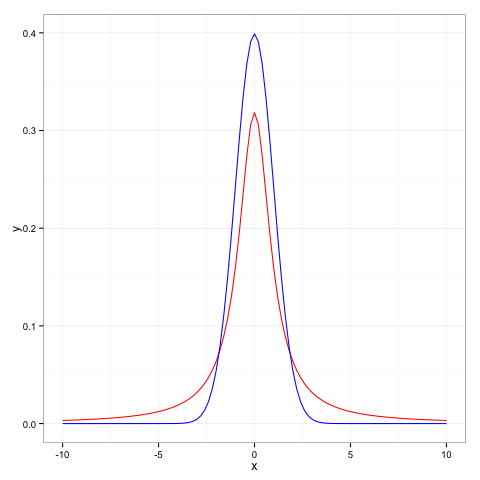

In [40]:
library(ggplot2)
ggplot(data.frame(x = c(-10, 10)), aes(x)) + 
    stat_function(fun = dcauchy, args = list(location = 0, scale = 1),
                  color = "red") +
    stat_function(fun = dnorm, args = list(mean = 0, sd = 1), 
                  color = "blue") +
    theme_bw()

###The entire model



The data are distributed as a Normal, with standardized effect size $\delta$:

$$y_i \sim  Normal(\delta \sigma_{\epsilon}, \sigma^2_\epsilon)$$

Inferences will be invariant to scale changes in the data:

$$p(\sigma_\epsilon) \propto \frac{1}{\sigma^2_\epsilon}$$ 


We will compare the model where $\delta=0$ to the one where $\delta \neq 0$ (with plausible $\delta$ values given by a Cauchy):

$$ \mathcal{M_0}: \delta = 0$$

$$ \mathcal{M_1}: \delta \sim Cauchy(r)$$



The scale parameter $r$ of the Cauchy distribution control the width of the prior distribution.

> **Exercise**: play around with the code given above.

BayesFactor has defaults for $r$.

> **Exercise**: Find out what these defaults are.

Hint: 
```R
?ttestBF
```

### Example

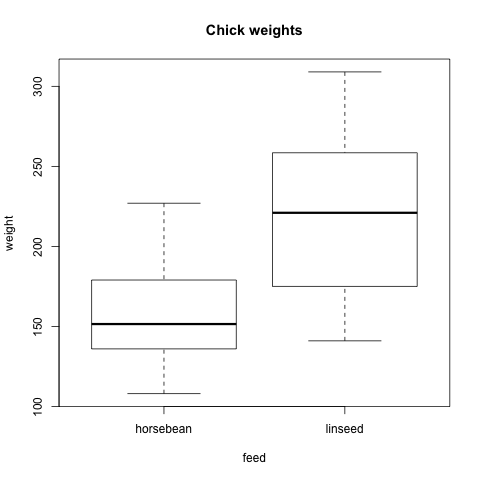

Bayes factor analysis
--------------
[1] Alt., r=0.707 : 5.975741 ±0%

Against denominator:
  Null, mu1-mu2 = 0 
---
Bayes factor type: BFindepSample, JZS


In [45]:
library(dplyr)
data(chickwts)

## Restrict to two groups
chickwts <- chickwts %>% filter(feed %in% c("horsebean", "linseed"))

## Drop unused factor levels
chickwts$feed = factor(chickwts$feed)

## Plot data
plot(weight ~ feed, data = chickwts, main = "Chick weights")

bf = ttestBF(formula = weight ~ feed, data = chickwts)
bf

## Bayesian ANOVA

```R
anovaBF(formula, data, whichRandom = NULL, whichModels = "withmain",
  iterations = 10000, progress = options()$BFprogress,
  rscaleFixed = "medium", rscaleRandom = "nuisance", multicore = FALSE,
  method = "auto", noSample = FALSE, callback = function(...)
  as.integer(0))
```

A one-way ANOVA model, with m levels:

$$ y_i = \mu + \beta_1 x_{1i} + \beta_2 x_{2i} + ...\beta_m x_{mi}+ \epsilon$$

$$\epsilon \sim Normal(0,\sigma^2_\epsilon)$$

...where $x_{ji}$ is a dummy variable (0 or 1) indicating membership in group level j, and $\mu$ is the grand mean.

Prior on $\mu$ and $\sigma_{\epsilon}$ are generalisations of the priors used in the t test.


We'd like to test $\mathcal{M_0}: \beta=0$ versus $\mathcal{M_0}: \beta \sim $?



- By what prior should we place on effects?

- How do we deal with random vs. fixed?
- How do we generalize to multiple factors?

As before, we consider the standardized parameter $\alpha = \frac{\beta}{\sigma_{\epsilon}}$.

The solution in the BayesFactor package is to place a multivariate normal distribution prior on the $\alpha$s. This is known as a 'g' prior. This is beyond the scope of this workshop...

But, we can note that this makes model hierarchical; effects come from a population.



### The whole model

- The data are a linear combination of a grand mean, effects of factor levels, and (mutually independent) random error terms.

- Inferences are invariant to arbitrary shifts and scaling (linear transformations) of the data.

- The factor level effects are from a normal population with unknown variance g.

- The expected effect size of the factor level effects is controlled by a scale parameter r.

### Example


In [42]:
# 2x2 (say, shape and color) within-subject ANOVA
data(puzzles)
puzzle_bf <- anovaBF(RT ~ shape + color + shape:color + ID, 
                     whichRandom = "ID", 
                     data = puzzles)

## How to use the package

Let's take a closer look at the 'puzzles' example.

The puzzles dataset is built into BayesFactor.

- 12 participants (ID) solved puzzles in each of four (2x2) conditions.
- Factors were shape of (round/square) and color (monochrome/color)
- Dependent variable was solving time (RT)

In [43]:
puzzle_bf

Bayes factor analysis
--------------
[1] shape + ID                       : 2.805976 ±0.88%
[2] color + ID                       : 2.819339 ±0.87%
[3] shape + color + ID               : 12.19759 ±3.87%
[4] shape + color + shape:color + ID : 4.16665  ±1.69%

Against denominator:
  RT ~ ID 
---
Bayes factor type: BFlinearModel, JZS


### BayesFactor's model notation

- tilde (~) means "predicted from"; separates response (RT) from predictor variables

- asterisk (*) means "expand to all main effects and interactions"
- colon (:) indicates an interaction

Thus 
``` R 
RT ~ shape*color + ID
``` 
is the same as 
``` R 
RT ~ shape + color + shape:color + ID
```

### BayesFactor and predictor types

BayesFactor guesses how to handle each factor:

- Continuous covariates are numerical non-factor columns in the data
- Categorical, fixed effects are factor columns not included in whichRandom
- Categorical, random effects are factor columns included in whichRandom

### Output: BayesFactor objects

A BayesFactor object returned for example by the `anovaBF()` contains:

- At least 1 numerator model
- Exactly 1 denominator model
- Estimates of Bayes factors comparing each numerator with the denominator
- Estimates of estimation error for each Bayes factor
- The original data
- Information about model assumptions ("JZS")

### Visualizing BF objects

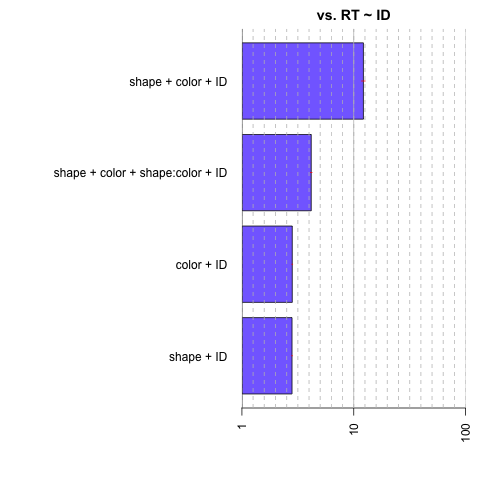

In [44]:
plot(puzzle_bf)